In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [2]:
# Download the dataset
dataframe = pd.read_csv('C:/Users/ASUS/Desktop/Dl/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

0         1         2         3         4         5         6    \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        7         8         9    ...       131       132       133       134  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

        135       136       137       138       139  140  
0  0.257740  0.228077  0.123431  0.925286  0.193137  1.0  
1  0.555784  0.476333  0.773820  1.119621 -1.436250  1.0  
2 -0.713683 -0.532197  0.321097  0.904227 -0.421797  1.0  
3  0.952074  0.990133  1.086798  1.403011 -0.383564  1.0  
4  1.277392  0.960304  0.971020  1.614392  1.421456  1.0  

[5 rows x 141 columns]

In [3]:
# The last element contains the labels
labels = raw_data[:, -1]        # [ALL ROWS , OF LAST COLUMN]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]       # [ALL ROWS , FROM COLUMN 0 TO SECOND LAST COLUMN; LAST COLUMN EXCLUDED ]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21  #RANDOM STATE MEANS BATCH SIZE
)

In [4]:
labels = raw_data[:, -1]      

In [5]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)  #NORMALISATION TO GET VALUES IN RANGE 0-1
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)     #CONVERTING DATATYPE TO FLOAT FROM ORIGINAL DATATYPE I.E INT
test_data = tf.cast(test_data, tf.float32)

In [6]:
train_labels = train_labels.astype(bool)      #converts TO BOOLEAN VALUES
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]  # LABEL TRUE THEN STORE IN NORMAL
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]  # LABEL FALSE THEN STORE IN NORMAL
anomalous_test_data = test_data[~test_labels]

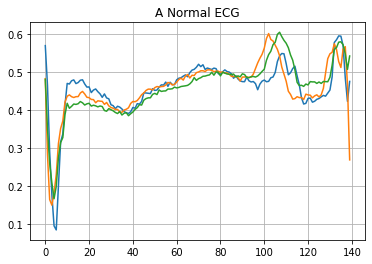

In [7]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])    #(NO. OF COLUMNS,DATA TO BE PLOT)
plt.plot(np.arange(140), normal_train_data[1])
plt.plot(np.arange(140), normal_train_data[2])
plt.title("A Normal ECG")
plt.show()

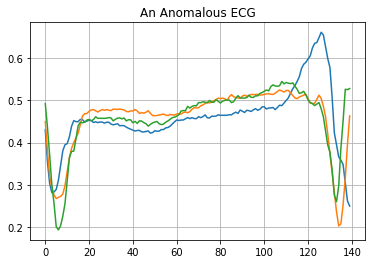

In [8]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.plot(np.arange(140), anomalous_train_data[1])
plt.plot(np.arange(140), anomalous_train_data[2])
plt.title("An Anomalous ECG")
plt.show()

In [9]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),   #ENCODER DOES DOWNSAMPLING
      layers.Dense(8, activation="relu")])  #TAKES DATA IN HIGHER DIMENSION AND CONVERTS INTO LOWER DIMENSION
                                            # CONVERTS DATA INTO 8 UNIT VECTOR & FOR RECONSTRUCTING USES DECODER

    self.decoder = tf.keras.Sequential([     #DECODER DOES UPSAMPLING MEANS RECONSTRUCTING DATA FROM LOWER DIMENSION TO HIGHER DIMENSION
      layers.Dense(16, activation="relu"),    #WHILE THIS RECONSTRUCTION, SOME AMOUNT OF DATA LOSS OCCURS CALLED AS RECONSTRUCTION ERROR
      layers.Dense(32, activation="relu"),      #RELU ADDS NON LINEARITY TO MODEL 
      layers.Dense(140, activation="sigmoid")]) #SIGMOID GIVES PROBABILISTIC VALUES OF OUTPUT BTWN 0-1

  def call(self, x):      
    encoded = self.encoder(x) # CALLING THE ENCODER AND PASSING THE INPUT
    decoded = self.decoder(encoded) #PASSING ENCODER TO DECODER 
    return decoded                  # GETTING THE DECODED OUTPUT

autoencoder = AnomalyDetector()

In [10]:
# TO RUN A KERAS MODEL WE NEED 2 PARAMETERS OPTIMIZER AND LOSS
#OPTIMIZER USED TO CONTROL LEARNING RATE AND WEIGHTS

# LOSS = A scalar value that we attempt to minimize during our training of the model.

# ADAM IS A ADVANCE VERSION OF SGD AND GIVES FASTER RESULT THAN SGD 
autoencoder.compile(optimizer='adam', loss='mae')  

In [11]:
#TRAIN THE MODEL
# TO .FIT WE HAVE TO PASS 2 ARGUMENTS DATA,LABEL BUT AS THIS IS AN UNSUPERVISED LEARNING
# WE NEED TO PASS DUMMY VALUES TO Y HENCE NORMAL_TRAIN_DATA AGAIN
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 40ms/step - loss: 0.0584 - val_loss: 0.0534
Epoch 2/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0561 - val_loss: 0.0517
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0529 - val_loss: 0.0499
Epoch 4/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0487 - val_loss: 0.0488
Epoch 5/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0448 - val_loss: 0.0465
Epoch 6/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0407 - val_loss: 0.0442
Epoch 7/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0370 - val_loss: 0.0430
Epoch 8/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0338 - val_loss: 0.0411
Epoch 9/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0313 - val_loss: 0.0402
Epoch 10/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0294 - val_loss: 0.0390
Epoch 11/20
5/5 [===================

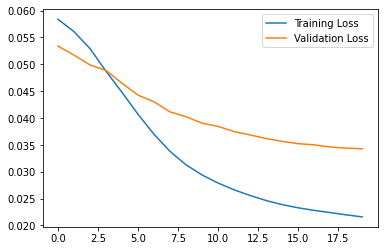

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [13]:
#TO USE ENCODER AND DECODER SEPARATELY
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

In [14]:
encoded_data.shape

(560, 8)

In [15]:
decoded_data.shape

(560, 140)

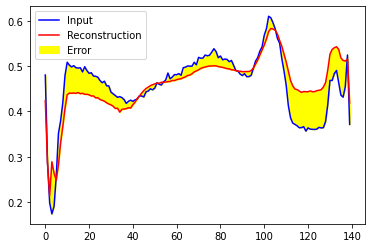

In [16]:
#graph for normal data

plt.plot(normal_test_data[0], 'b')   #data to be tested
plt.plot(decoded_data[0], 'r')       #predicted output
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='yellow')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

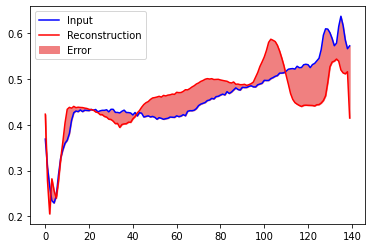

In [17]:
#graph for anomalous data

encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

74/74 [==============================] - 0s 1ms/step


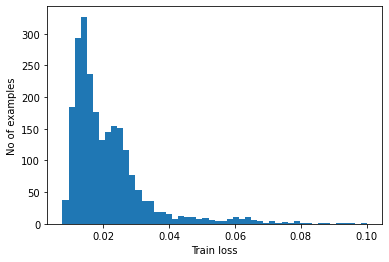

In [18]:
reconstructions = autoencoder.predict(normal_train_data) #passing normal train data to autoencoder to predict output
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)  #find loss between reconstruction and 

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [19]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033489235


14/14 [==============================] - 0s 1ms/step


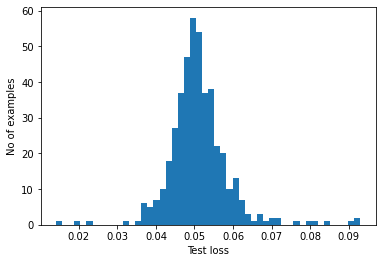

In [20]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [21]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [23]:
preds = predict(autoencoder, test_data, threshold)

print_stats(preds, test_labels)

tf.Tensor(
[False False  True  True False False  True  True False  True False  True
 False  True False  True  True  True False False False  True  True  True
  True  True  True  True False  True  True  True  True  True  True False
 False False  True False  True False  True  True  True  True  True False
 False  True  True False False False  True False  True  True False False
 False  True  True False False  True False False  True  True False  True
 False False  True False False  True  True  True  True False False  True
 False  True False False False  True  True False False False  True False
  True False False  True False  True False  True  True  True False  True
 False False  True  True False  True False  True  True False False  True
 False  True  True  True False  True False  True  True False False  True
 False  True False False  True  True  True  True False False False False
 False  True  True  True  True  True False  True  True False  True  True
 False False  True False  True  True  Tr